Text(0.5, 0, 'Token count')

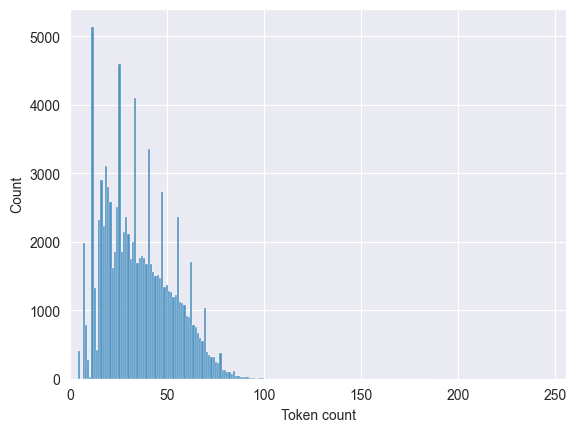

In [3]:
# Training a model using Twitter dataset and LSTM model
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from datetime import datetime
from transformers import DistilBertTokenizer
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# methods
def data_cleaning(data):
    # cleaning repetitive char
    data = re.sub(r'(.)\1+', r'\1', data)
    # cleaning usernames
    data = re.sub('@[^\s]+', ' ', data)
    # cleaning URLs
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|([^\s]+\.com))',' ',data)
    # cleaning numerical numbers
    data = re.sub('[0-9]+', '', data)
    return data

def cleaning_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def stemming_on_text(data):
    st = nltk.PorterStemmer()
    data = [st.stem(word) for word in data]
    return data

def lemmatizer_on_text(data):
    lm = nltk.WordNetLemmatizer()
    data = [lm.lemmatize(word) for word in data]
    return data

# prepare dataset
df = pd.read_csv(r'C:\Users\Senju\Documents\_Solent\_Dissertation\training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.columns=['label','b','c','d','e','tweet']
df = df[['label','tweet']] # label aka class label, target variable
df.loc[df['label'] == 4, 'label'] = 1 # convert all values of 4 to 1 (positive sentiment)
positive = df[df['label'] == 1] # split the dataframe into positive and negative sentiment
negative = df[df['label'] == 0]
positive = positive.iloc[:int(50000)] # reducing the data for smoother operation flow
negative = negative.iloc[:int(50000)]
df = pd.concat([positive, negative]) # combine into one dataframe

# data cleaning
df['tweet'] = df['tweet'].str.lower() # to lowercase
df['tweet'] = df['tweet'].apply(lambda x: data_cleaning(x))
df['tweet'] = df['tweet'].apply(lambda x: cleaning_punctuations(x))
df['tweet'] = df['tweet'].apply(lambda x: cleaning_stopwords(x))

# tokenization (separate sentence into words)
# this step raised both the train and test accuracy
tokenizer = nltk.RegexpTokenizer(r'\w+')
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

# stemming and lemmatization
df['tweet'] = df['tweet'].apply(lambda x: stemming_on_text(x))
df['tweet'] = df['tweet'].apply(lambda x: lemmatizer_on_text(x))

# X (input), y (output)
X = df['tweet']
y = df['label']

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Store length of each review 
token_lens = []
df['tweet'] = df['tweet'].astype(str)

# Iterate through the content slide
for txt in df['tweet']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
# plot the distribution of review lengths 
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

# plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\lstm_max_length.png')

In [4]:
# tokenization
max_length = 140
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_length)

# train set size (80%), test set size (20%)
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=42)

In [5]:
def implement_model():
    inputs = Input(name='inputs',shape=[max_length]) # input info
    layer = Embedding(2000,50,input_length=max_length)(inputs) # convert input information into low-dimensional vector space
    layer = LSTM(64)(layer) # LSTM layer
    layer = Dense(256,name='FC1')(layer) # introduces non-linearity property, to model any mathematical function
    layer = Activation('relu')(layer) # ReLU - introduces non-linearity property and solves vanishing gradients problem
    layer = Dropout(0.5)(layer) # prevents overfitting in nn
    layer = Dense(1,name='out_layer')(layer) # classifies the tweet as positive or negative
    layer = Activation('sigmoid')(layer) # for BCE loss function
    model = Model(inputs=inputs,outputs=layer) # passes the output value in the model
    return model

In [6]:
model = implement_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy']) # binary accuracy

In [9]:
start_time = datetime.now()
history=model.fit(X_train,Y_train,batch_size=32,epochs=2, validation_split=0.1)
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()
print('Training completed')

Epoch 1/2
2250/2250 [==============================] - 42s 19ms/step - loss: 0.4832 - accuracy: 0.7700 - val_loss: 0.4937 - val_accuracy: 0.7699
Epoch 2/2
2250/2250 [==============================] - 42s 19ms/step - loss: 0.4751 - accuracy: 0.7748 - val_loss: 0.4891 - val_accuracy: 0.7689
Training completed


In [27]:
print('Training accuracy: {:.1%}'.format(history.history['accuracy'][-1]))
print('Validation accuracy: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_tf, training_time_tf/60))

Training accuracy: 77.5%
Validation accuracy: 76.9%
Training time: 84.0s (or 1.4 minutes)


In [28]:
save_as = 'LSTM_tf_epoch2'

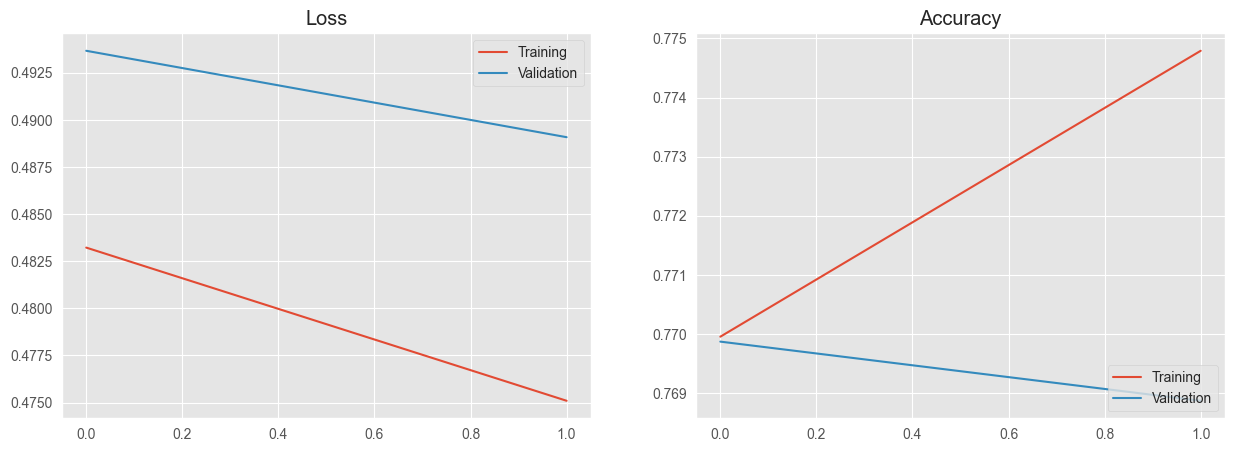

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right") 

#plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\h5\\' + save_as + '.png')

625/625 [==============================] - 4s 7ms/step


confusion matrix


[[7474 2491]
 [2139 7896]]


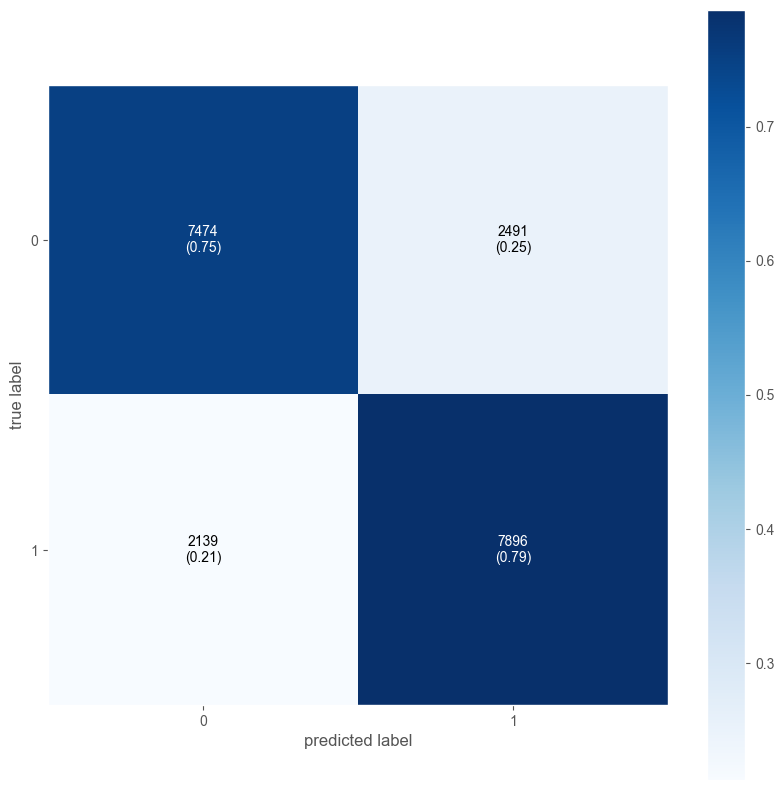

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

#plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\h5\\conf_mtrx_' + save_as + '.png', dpi=600)

plt.show()

save_as = save_as + '.h5'

In [32]:
# save trained model
model.save('LSTM_tf_epoch2.h5', save_format='h5')

In [33]:
# load existing model
from tensorflow.keras import models
model2 = models.load_model('LSTM_tf_epoch2.h5')
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 50)           100000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [10]:
# sentiment analysis

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import models

# load existing model
model = models.load_model('LSTM_tf_epoch2.h5')
#model.summary()

# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

# tokenization
tokenizer = Tokenizer(num_words=2000, oov_token='')
tokenizer.fit_on_texts(sentence)
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
sequences_matrix = sequence.pad_sequences(sequences, maxlen=140)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(sequences_matrix)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 193ms/step
The movie was very touching and heart whelming
Predicted sentiment :  Positive
I'm thrilled and happy
Predicted sentiment :  Positive
the movie plot is terrible but it had good acting
Predicted sentiment :  Negative
